RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)




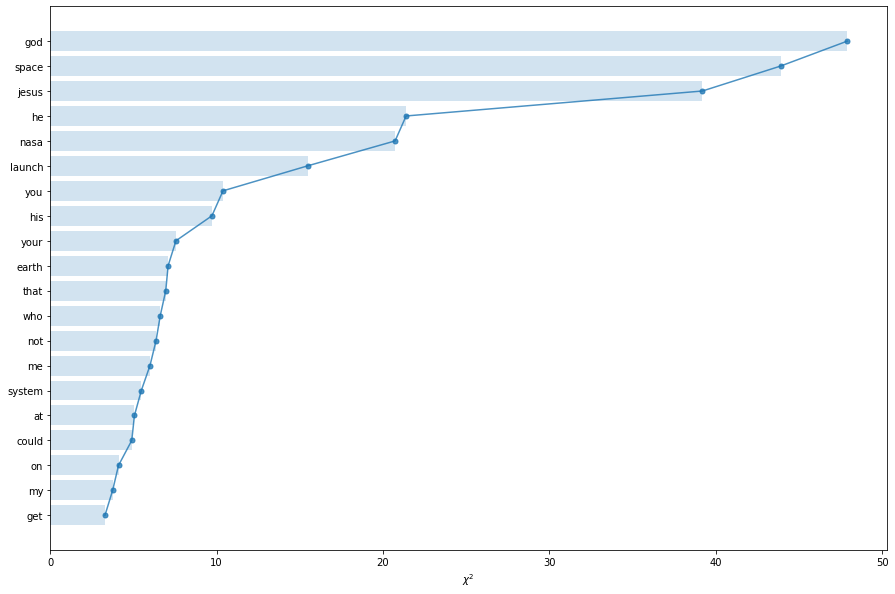

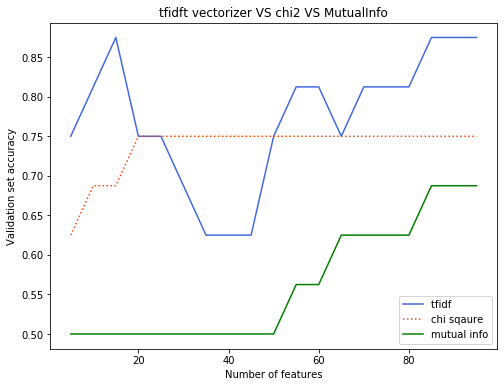

In [31]:
#importing all required pacakge

import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import logging
from time import time
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer , CountVectorizer
from sklearn.feature_selection import SelectKBest, chi2 , mutual_info_classif
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB, MultinomialNB

#Getting Selected categories only from data
categories = [ 'sci.space','talk.religion.misc']

#removing extra data

remove = ('headers', 'footers', 'quotes')

d = fetch_20newsgroups(subset='all', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)
x = d.data
y=d.target

from sklearn.model_selection import train_test_split
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)



"""

#getting traing data

train_data = fetch_20newsgroups(subset='train', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)
y_train = train_data.target
x_train = train_data.data

#getting test data

test_data =  fetch_20newsgroups(subset='test', categories=categories,
                                shuffle=True, random_state=42,
                                remove=remove)
y_test = test_data.target
x_test = test_data.target

"""

#getting accuracy summary


def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    
    #print ("accuracy score: {0:.2f}%".format(accuracy*100))

    
    return accuracy, train_test_time

cvec = CountVectorizer()
#lr = LogisticRegression()
lr = MultinomialNB()
n_features = np.arange(5,100,5)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words='english',  classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        #print ("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result
tvec = TfidfVectorizer()

print ("RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec)
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])


tvec = TfidfVectorizer(max_features=100)
x_train_tfidf = tvec.fit_transform(x_train)
x_validation_tfidf = tvec.transform(x_validation)
chi2score = chi2(x_train_tfidf, y_train)[0]
plt.figure(figsize=(15,10))
wscores = zip(tvec.get_feature_names(), chi2score)
wchi2 = sorted(wscores, key=lambda x:x[1])
topchi2 = zip(*wchi2[-20:])
c = list(topchi2)
x = range(len(c[1]))
labels = c[0]
plt.barh(x,c[1], align='center', alpha=0.2)
plt.plot(c[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')

ch2_result = []
for n in np.arange(5,100,5):
    ch2 = SelectKBest(chi2, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
    x_validation_chi2_selected = ch2.transform(x_validation_tfidf)
    #clf = LogisticRegression()
    clf = MultinomialNB()
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_validation)
    ch2_result.append(score)
    #print "chi2 feature selection evaluation calculated for {} features".format(n)


m2_result = []
for n in np.arange(5,100,5):
    ch2 = SelectKBest(mutual_info_classif, k=n)
    x_train_chi2_selected = ch2.fit_transform(x_train_tfidf, y_train)
    x_validation_chi2_selected = ch2.transform(x_validation_tfidf)
    clf = MultinomialNB()
    #clf = LogisticRegression()
    clf.fit(x_train_chi2_selected, y_train)
    score = clf.score(x_validation_chi2_selected, y_validation)
    m2_result.append(score)
    #print "chi2 feature selection evaluation calculated for {} features".format(n)

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='tfidf ',color='royalblue')
plt.plot(np.arange(5,100,5), ch2_result,label='chi sqaure',linestyle=':', color='orangered')
plt.plot(np.arange(5,100,5), m2_result,label='mutual info',linestyle='solid', color='green')

plt.title("tfidft vectorizer VS chi2 VS MutualInfo")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()